# A Python Based Approach to Statistical Arbitrage Pair Trading
Many pairs of publically traded companies share near identical exposure to different risk factors. As a result of this, their share prices experience similar movements regardless of overall market trends. When these movements suddenly differ as a result of unbased changes in market attitude towards the companies, an arbitrage opportunity is created by the relative change in spread between the share prices. By systematially identifying these opportunities, and opening long and short positions based on them, we should be able to outperform the S&P500.

## Contents
### [1. Introduction](#1-Introduction)
#### [1.1 Purpose](#1-1-Purpose)
#### [1.2 Scope](#1-2-Scope)
#### [1.3 Data](#1-3-Data)
#### [1.4 Success Criteria](#1-4-Success-Criteria)
#### [1.5 Document Structure](#1-5-Document-Structure)
### [2. Feature Generation](#2-Feature-Generation)
#### [2.1 Qualitative Data](#2-1-Qualitative-Data)
#### [2.2 Fundamental Data](#2-2-Fundamental-Data)
#### [2.3 Historical Price Data](#2-3-Historical-Price-Data)
#### [2.4 Vector Creation](#2-4-Vector-Creation)
### [3. Pair Selection](#3-Pair-Selection)
#### [3.1 Clustering](#3-1-Clustering)
#### [3.2 Pair Iteration](#3-2-Pair-Iteration)
### [4. Signal Logic](#4-Signal-Logic)
#### [4.1 Signal Generation](#4-1-Signal-Generation)
#### [4.2 Signal Rationale](#4-2-Signal-Rationale)
### [5. Portfolio Allocation](#5-Portfolio-Allocation)
#### [5.1 Equal Weight](#5-1-Equal-Weight)
#### [5.2 Rebalancing](#5-2-Rebalancing)
### [6. Results](#6-Results)
### [6.1 Correlation](#6-1-Correlation)
### [7. Conclusion](#7-Conclusion)

## Introduction <a id='1-Introduction'></a>
Predicting the direction of stock prices has been one of the most studied topics, with approaches ranging a myriad of disciplines from economics to physics. The driver of this being the profitability of the ability to successfully forecast the direction of stock prices. There are endless approaches to doing so, but nearly none are 100% accurate, and those that are have exposure to realistic risks that count end their accuracy. Technical and fundamental analysis have significant shortcomings that not only limit accuracy, but can erase profits and lead to losses. A main driver of strategy risk is exposure to market movements. Very few cmompanies have a correlation of 0 with the market, thus their movement is affected to varying degrees by the market. A way to eliminate this risk is pairs trading, a market neutral approach to investing.

The efficient market theory states that... . Assuming that markets like the NYSE and NASDAQ are inefficient by this definition, and the general trend is toward efficiency, there should exist opportunities to profit off of inefficencies following this trend. These opportunities, refered to as statistical arbitrage in this paper, offer market neutral opportunies to profit off of inefficiencies.

Much is known about statistical arbitrage...

Existing research and strategies regarding statistical arbitrage are not perfectly eficient, and leave room to be optimized. The conventional approach to identifying pairs to trade is to look at only historical price data. I will be researching whther or not using other fundamental company data when identifying the pairs provides excess returns with minimized risk when compared to strategies only using historical price data. Additionaly, I will be examining whethr there exist opportunities in which it is optimal to trade three or more companies in concurrene to capture the most profit off of the srbitrage opportunity.

#### 1.1 Purpose <a id='1-1-Purpose'></a>
The purpose of the thesis is to create a market neutral strategy to systematically identify cointegrated pairs of stocks and predict their relative movements to identify investment opportunities. The system could be used manually, or automated to maximize efficiency.
    Data --> Cluster Identification --> Pair Selection --> Cointegration Filter --> Investment Opportunity
    
The model is a multi-step approach, each step further narrowing down the tradeable universe of stocks until signals can be generated to either buy or sell a company. The pairs are selected through the generation of feature vectors, which are used to calculate the mathematical distance between two companies. Through clustering, the closest copmanies are paired together. The buy/sell signals are generated based on the scaled spread's distance from the mean spread of the two share prices. This will only work if the scaled spread is a time series, which is one of the criteria when filtering out pairs, which would ensure that the spread is mean reverting.
    

#### 1.2 Scope <a id='1-2-Scope'></a>
The domain of knowledge implemented in this strategy includes historical prices, company fundamentals, and qualitative descriptive information about companies. Thus the data is limited to publically available information regarding companies in the S&P500. This data is quantified through feature vectors of diferent companies. The evaluation metric is the performance of the SP&P500 relative to that of the strategy, so the index fund SPY which tracks the performance of the S&P500 is used.

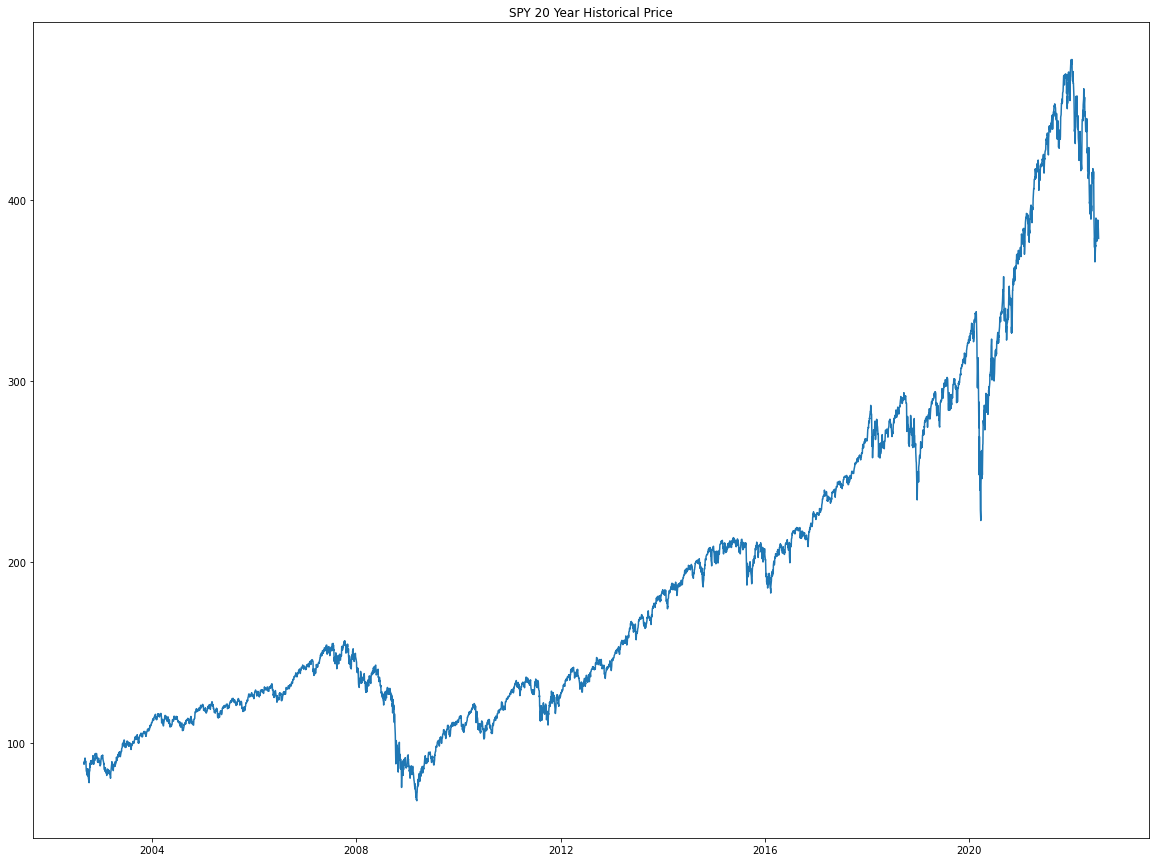

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

closes20year = yf.download('SPY', progress=False)['Close'][-5000:]
fig = plt.figure(figsize=(20,15))
plt.plot(closes20year)
plt.title('SPY 20 Year Historical Price')
plt.show()

#### 1.3 Data <a id='1-3-Data'></a>
The data used for company fundamentals and descriptive data is Core US Fundamental Data by Sharadar on Quandl. The python library yfinance is used to download historical price data from Yahoo Finance. The TD Ameritrade API is used to fetch live prices. Due to the limitations of using an open source web scraping API for historical data, there is missing data on many companies which limited the data in this research, however more comprehensive data is available for a higher price.

#### 1.4 Success Criteria <a id='1-4-Success-Criteria'></a>
There are multiple degrees of success to this thesis, which all strive to answer the question of *"What returns can this strategy produce"*. The first measure of success is basic profitability. That is, that the strategy produces any sort of positive return. The second measure is relative performance to the market. How do the strategy's returns compare to those of the overall market, in this case the S&P500. By comparing the strategy performance to these metrics, we can determine both the theoretical success of the model, as well as whether or not it is a more desirable approach to investing than the overall market.

#### 1.5 Document Structure <a id='1-5-Document-Structure'></a>
The remainder of this thesis is structured as follows
##### Feature Generation
Describes the features used to select pairs, as well as the techniques used to clean the data
##### Pair Selection 
Describes the process by which pairs are selected using the generated features
##### Signal Logic
Describes the process by which signals are generated, as well as the theoretical logic behind them explaining why they work
##### Portfolio Allocation
Describes the techniques used to allocate money in the portfolio as well as those used to rebalance the portfolio
##### Results
Evaluates the performance of the model compared to the evaluation metrics
##### Conclusion
Contains a brief summarization and discussion of the results and their implications

## Feature Generation <a id='2-Feature-Generation'></a>
The purpose of feature generation is to quantify to risk factors associated with a company, and out them into a one dimensional numerical vector. The process uses. multitude of data cleaning techniques used to turn any descriptive variable into a number. These vectors are later used to identify and select pairs of cointegrated companies.

### 2.1 Qualitative Data <a id='2-1-Qualitative-Data'></a>
For this research, the qualitative features associated with a company are Sector, Sub-Sector, and Industry. While qualitative in nature, there are a limited amount of sectors, sub-sectors, and industries. As a result of this, through one-hot encoding we can quantify these features. Each potential sector, sub-sector, and industry becomes a column in the vector. The column value is either a 1 or a 0, a one indicating that the given column represents that company's respective sector, sub-sector, or industry. While this greatly increases the length of the vectors, it allows for a more accurate pairing, as companies with common sectors, sub-sectors, and industries share a large proportion of identical risk exposure.

### 2.2 Fundamental Data <a id='2-2-Fundamental-Data'>
The fundamental data used for this is limited to scale of market cap, an integer 1-5 representing the magnitude of the market cap, and the scale of revenue, another integer 1-5. The fundamental data is limited to these two, as these two characterize the vast majority of risk exposure that can be shared based off of fundamental data. These two indicators provide the most insight into potential shared risk exposure than any other fundamental piece of data.

In [2]:
import os
f = os.path.expanduser('/Users/nicholasaronow/Desktop/jupyter-notebooks/datasets/SHARADAR-TICKERS.csv')
metadata = pd.read_csv(f)

dummies = pd.get_dummies(metadata['sicsector'])
metadata = pd.concat([metadata, dummies], axis=1).drop('sicsector', axis=1)

dummies = pd.get_dummies(metadata['sector'])
metadata = pd.concat([metadata, dummies], axis=1).drop('sector', axis=1)

dummies = pd.get_dummies(metadata['industry'])
metadata = pd.concat([metadata, dummies], axis=1).drop('industry', axis=1)

metadata['scalemarketcap'] = metadata['scalemarketcap'].str[:1]
metadata['scalerevenue'] = metadata['scalerevenue'].str[:1]

columns = ['ticker','scalemarketcap','scalerevenue','Agriculture Forestry And Fishing',
             'Construction','Finance Insurance And Real Estate','Manufacturing','Mining','Nonclassifiable','Retail Trade',
             'Services','Transportation Communications Electric Gas And Sanitary Service',
             'Wholesale Trade','Basic Materials','Communication Services','Consumer Cyclical','Consumer Defensive',
             'Energy','Financial Services','Healthcare','Industrials','Real Estate','Technology','Utilities',
             'Advertising Agencies','Aerospace & Defense','Agricultural Inputs','Airlines','Airports & Air Services','Aluminum',
             'Apparel Manufacturing','Apparel Retail','Apparel Stores','Asset Management','Auto & Truck Dealerships','Auto Manufacturers',
             'Auto Parts','Banks - Diversified','Banks - Regional','Banks - Regional - US','Beverages - Brewers',
             'Beverages - Non-Alcoholic','Beverages - Wineries & Distilleries','Biotechnology','Broadcasting','Building Materials','Building Products & Equipment','Business Equipment','Business Equipment & Supplies','Business Services',
             'Capital Markets','Chemicals','Coal','Coking Coal','Communication Equipment','Computer Hardware','Computer Systems',
             'Confectioners','Conglomerates','Consulting Services','Consumer Electronics','Copper','Credit Services',
             'Department Stores','Diagnostics & Research','Discount Stores','Diversified Industrials','Drug Manufacturers - General','Drug Manufacturers - Major',
             'Drug Manufacturers - Specialty & Generic','Education & Training Services','Electrical Equipment & Parts',
             'Electronic Components','Electronic Gaming & Multimedia',
             'Electronics & Computer Distribution','Engineering & Construction','Entertainment','Farm & Construction Equipment','Farm & Heavy Construction Machinery',
             'Farm Products','Financial Conglomerates','Financial Data & Stock Exchanges','Financial Exchanges',
             'Food Distribution','Footwear & Accessories','Furnishings','Furnishings Fixtures & Appliances','Gambling','Gold',
             'Grocery Stores','Health Care Plans','Health Information Services','Healthcare Plans','Home Improvement Retail',
             'Household & Personal Products','Industrial Distribution',
             'Industrial Metals & Minerals','Information Technology Services','Infrastructure Operations','Insurance - Diversified','Insurance - Life',
             'Insurance - Property & Casualty','Insurance - Reinsurance','Insurance - Specialty','Insurance Brokers',
             'Integrated Freight & Logistics','Internet Content & Information','Internet Retail','Leisure','Lodging','Long-Term Care Facilities',
             'Lumber & Wood Production','Luxury Goods','Marine Shipping','Media - Diversified','Medical Care','Medical Care Facilities','Medical Devices',
             'Medical Distribution','Medical Instruments & Supplies','Metal Fabrication',
             'Mortgage Finance','Oil & Gas Drilling','Oil & Gas E&P','Oil & Gas Equipment & Services','Oil & Gas Integrated',
             'Oil & Gas Midstream','Oil & Gas Refining & Marketing','Other Industrial Metals & Mining','Other Precious Metals & Mining',
             'Packaged Foods','Packaging & Containers','Paper & Paper Products','Personal Services','Pharmaceutical Retailers',
             'Pollution & Treatment Controls','Publishing','REIT - Diversified','REIT - Healthcare Facilities',
             'REIT - Hotel & Motel','REIT - Industrial','REIT - Mortgage','REIT - Office','REIT - Residential','REIT - Retail',
             'REIT - Specialty','Railroads','Real Estate - Development','Real Estate - Diversified','Real Estate - General',
             'Real Estate Services','Recreational Vehicles','Rental & Leasing Services','Residential Construction',
             'Resorts & Casinos','Restaurants','Savings & Cooperative Banks','Scientific & Technical Instruments',
             'Security & Protection Services','Semiconductor Equipment & Materials','Semiconductor Memory','Semiconductors','Shell Companies','Shipping & Ports','Silver','Software - Application',
             'Software - Infrastructure','Solar','Specialty Business Services','Specialty Chemicals','Specialty Finance',
             'Specialty Industrial Machinery','Specialty Retail','Staffing & Employment Services','Staffing & Outsourcing Services','Steel','Telecom Services',
             'Textile Manufacturing','Thermal Coal','Tobacco','Tools & Accessories','Travel Services','Trucking','Uranium',
             'Utilities - Diversified','Utilities - Independent Power Producers','Utilities - Regulated Electric',
             'Utilities - Regulated Gas','Utilities - Regulated Water','Utilities - Renewable','Waste Management']

usefuldata = metadata[columns]

usefuldata = usefuldata.set_index('ticker', drop=True)
usefuldata['scalerevenue'] = pd.to_numeric(usefuldata['scalerevenue'])
usefuldata['scalemarketcap'] = pd.to_numeric(usefuldata['scalemarketcap'])

quandldata = usefuldata.dropna()

quandldata.head()

,scalemarketcap,scalerevenue,Agriculture Forestry And Fishing,Construction,Finance Insurance And Real Estate,Manufacturing,Mining,Nonclassifiable,Retail Trade,Services,...,Travel Services,Trucking,Uranium,Utilities - Diversified,Utilities - Independent Power Producers,Utilities - Regulated Electric,Utilities - Regulated Gas,Utilities - Regulated Water,Utilities - Renewable,Waste Management
ticker,,,,,,,,,,,,,,,,,,,,,
A,5.0,5.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AA,4.0,5.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAB,2.0,1.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAGY,4.0,4.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAP,4.0,2.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 Historical Price Data <a id='2-3-Historical-Price-Data'></a>
The final component of the vectors is the relative share price motion over a set time period. Using yfinance, the historical close prices for the companies are turned into the percent change from the previous day. This scales all the companies' data into relative movement in relation to itself. These percent changes, in decimal form, are added onto the vector in order. The purpose of this is to capture the historical price movements of companies relative to eachother, under the assumption that stocks that have shared extremely similar price movement will continue to do so due to their shared risk exposure.

In [3]:
import yahoo_fin.stock_info as si
import datetime as datetime

sp500 = si.tickers_sp500()

end = datetime.datetime.now()
start = end - datetime.timedelta(days=500)

data = yf.download(sp500,start,end, threads=False, interval='1d', progress=False)

closes = data['Adj Close']
if len([x for x in pd.isnull(closes[:1].values[0]) if x == False]) == 0:
    closes = closes[1:]
if len([x for x in pd.isnull(closes[:1].values[0]) if x == False]) == 0:
    closes = closes[1:]
        
closes = closes[:-1]
closes = closes.dropna(axis=1)
IntervalCloses = closes

IntervalCloses.head()


2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,123.397644,21.180000,157.613480,126.848587,102.710205,101.398201,324.260010,119.931847,254.460037,469.570007,...,131.789993,56.725239,52.900784,58.926029,100.845779,102.295494,156.961456,511.480011,53.137688,156.542984
2021-03-02,122.564941,21.440001,159.725845,124.198265,102.179642,102.459663,325.309998,120.245880,255.514694,466.589996,...,133.000000,56.562210,52.591255,58.491802,100.579422,102.520622,154.838547,501.619995,52.604279,155.907639
2021-03-03,118.262680,22.170000,160.685135,121.160797,101.099571,101.565277,307.600006,116.958321,250.537048,448.450012,...,135.619995,55.651146,53.013336,59.360252,99.770531,101.316689,153.455307,489.549988,52.604279,148.233871
2021-03-04,113.990143,21.240000,160.404099,119.245018,100.095314,101.221298,295.630005,113.847435,243.459976,439.059998,...,132.889999,56.504662,55.067455,57.939159,97.166283,101.375420,150.093201,479.640015,52.332718,142.952560
2021-03-05,115.130150,20.450001,166.188904,120.525513,101.090096,103.029701,301.220001,115.064308,245.934006,440.829987,...,133.320007,58.835049,57.149727,59.212219,98.882713,102.119316,152.254547,478.149994,54.107533,144.620346


### 2.4 Vector Creation <a id='2-4-Vector-Creation'></a>
With all the numerical data compiled into arrays, all the data for each company is combined into a single, one dimensional array called a vector. This vector contains the qualitative, fundamental, and historical data for each copmany, and becomes a representation of the risk profile of that copmany. These vectors can be compared against one another to identify similar companies with similar risk exposure.

In [4]:
import numpy as np

arrays = []
stock_order = []


for ticker in IntervalCloses.columns:
    try:
        data = IntervalCloses[ticker]   
        metdat = quandldata.loc[ticker].values[0]
        cdat = data.pct_change().dropna()
        closes_array = np.array(cdat)

        array = np.concatenate([metdat, closes_array])
        arrays.append(array)
        stock_order.append(ticker)

    except Exception:
           pass
IntervalArrays = np.array(arrays)

## Pair Selection </a> <a id='3-Pair-Selection'></a>
With the created vectors, the next step is to select pairs of cointegrated stocks. This is the first major change from the hand picked pair trading strategy. Pairs are systematically selected from the vectors through the use of clustering, and the use of euclidean distance. Those companies that form a "cluster" with their vectors are further separated into one or more pairs. This is a quantifiable way of identifying and selecting cointegrated companies which brings us one step closer to trading off of the strategy.

### 3.1 Clustering </a> <a id='3-1-Clustering'></a>
OPTICS stands for Ordering Points to Identify Cluster Structure, and it is the technique used to identify pairs. Through the use of OPTICS, optimized clusters are identified, giving insight into the most closely related companies. Stocks in the same cluster fit the first criteria of cointegration, and they pass through the first filter. Most companies are not cointegrated with one another, so this course technique of filtering both eliminates unusable stocks, while grouping up the usable stocks into clusters.

In [5]:
from sklearn.cluster import OPTICS


clustering = OPTICS(min_samples=2).fit(IntervalArrays)

labels = clustering.labels_

labels_dict = {}
for i in range(len(list(labels))):
    labels_dict[stock_order[i]] = labels[i]

clustersDictionary = {k: v for k, v in sorted(labels_dict.items(), key=lambda item: item[1])}

clusterFrame = pd.DataFrame(clustersDictionary, index=[0]).T
clusterFrame= clusterFrame[clusterFrame[0] != -1]

### 3.2 Pair Iteration </a> <a id='3-2-Pair-Iteration'></a>
While some of the clusters only contain two companies, many of them contain three or more. To solve for this issue, when more than two stocks exist in the same cluster, every possible combination of paris in that cluster is created. This not only allows for greater diversification of investments, but it gives more opportunities to further identify cointegrated stocks. To do this, the itertools python library is used to iterate through the clusters and create a comprehensive list of all combinations of usable pairs.

In [6]:
import itertools

pairs_list = []
for val in clusterFrame[0].unique():
    data = clusterFrame[clusterFrame[0] == val]
    values = (data.index.values)
    if len(values) == 2:
        pairs_list.append(list(values))
    else:
        [pairs_list.append(list(x)) for x in list(itertools.combinations(values, 2))]

## Signal Logic </a> <a id='4-Signal-Logic'></a>
To actually trade with the pairs, some sort of logic is needed to determine when to open and close positions. In this scenario, that logic is based off of mean reversion. When the spread between two cointegrated stocks passes a certain threshold, we expect it to revert to the mean. Through this reversion, a theoretically risk-free profit can be generated. The logic is simple - When the scaled spread passes a set value, long and short positions in the two companies are entered to capture any possible gain. The positions are eited when the spread either reverts to the mean, or diverts past a certain stop loss.

### 4.1 Signal Generation </a> <a id='4-1-Signal-Generation'></a>
In order to generate a signal, the historical closes for each pair must be retrieved, scaled, and subtracted from one another to find the scaled spread. The scaled spread is crucial, as that is the metric used to evaluate the relative movements of each company. Additionally, it can be used with the AD Fuller test to determine whether or not it is a time series. If the spread is a time series, it is mean reverting and can be used to generate trade signals. For this research, the threshold was not optimized and was set at the constant of 1.5. It would be challenging to optimize such a variable without overfiutting to historical data, so the size of the number is merely and indicator of desired trade frequency. The lower the number, the more trades entered. Depending on the magnitude (positive or negative) of the spread, long and short positions will be entered in the two companies. An additional criteria is added for a signal to be generated, which we will call "gravity". Since cointegrated companies are mean reverting in both the short term, and long term, the short term spread movements will gradually follow those of the long term. The gravity condition is as follows - if a short term long signal is generated for company A and short signal for company B, a position can only be entered if the long term trend is the same; long company A and short company B. This is quantified by only entering trades when the sign of the long term spread is the same as the short term which triggered the trade signal.

In [7]:
from td.client import TDClient
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller

CLIENT_ID = 'YNKJYBFNCWJJ1S9GLISEV97XJWDDJMU1'
REDIR_URI = 'https://localhost'


TDSession = TDClient(client_id=CLIENT_ID,
                             redirect_uri= REDIR_URI)
TDSession.login()

universe = IntervalCloses.columns

all_changes = []
trades = []

buys = []
shorts = []
sells = []
covers = []

crit_fit = []

end = datetime.datetime.now()
start = end - datetime.timedelta(days=500)

rebal_quotes1 = TDSession.get_quotes(instruments=universe[:len(universe)//2])
rebal_quotes2 = TDSession.get_quotes(instruments=universe[len(universe)//2:])
rebal_quotes = {**rebal_quotes1, **rebal_quotes2}

for set_ticks in pairs_list:
    try:
        s1 = set_ticks[0]
        s2 = set_ticks[1]

        stock1data = IntervalCloses[s1]
        stock2data = IntervalCloses[s2]
        scaler1 = MinMaxScaler()
        scaled1 = scaler1.fit_transform(np.array(stock1data).reshape(-1,1))

        scaler2 = MinMaxScaler()
        scaled2 = scaler2.fit_transform(np.array(stock2data).reshape(-1,1))

        spread =  scaled1 - scaled2
        scalerS = StandardScaler()
        spread = scalerS.fit_transform(np.array(spread).reshape(-1,1))

        livestock1 = rebal_quotes[s1]['lastPrice']
        livestock2 = rebal_quotes[s2]['lastPrice']

        spreadlive = (scalerS.transform(scaler1.transform(np.array(livestock1).reshape(-1,1)) - 
                                         scaler2.transform(np.array(livestock2).reshape(-1,1))))[0][0]


        position1 = 0
        position2 = 0
        
        crosses = [x for x in range(1, len(spread)) if np.sign(spread[x])!=np.sign(spread[x-1])]
        p_val = adfuller(spread)[1]

    
        
        if len(crosses) >= 12 and p_val <=.1:

            crit_fit.append([s1,s2])
        
            if spreadlive <= 0:
                            # Cover 1 Sell 2
                covers.append(s1)
                sells.append(s2)

            if spreadlive >= 0:
                            # Cover 2 Sell 1
                covers.append(s2)
                sells.append(s1)


            if spreadlive >= 2 and spreadlive <=4:
                        # Short 1 Buy 2
                
                buys.append(s2)
                shorts.append(s1)

            if spreadlive <=-2 and spreadlive >=-4:
                        # Short 2 Buy 1
                buys.append(s1)
                shorts.append(s2)
    except Exception:
        pass
print(crit_fit)

[['MTD', 'PKI'], ['IQV', 'LH'], ['LLY', 'MRK'], ['MRNA', 'TECH'], ['ADM', 'TSN'], ['DE', 'PCAR'], ['AAL', 'LUV'], ['AAL', 'UAL'], ['LUV', 'UAL'], ['FTV', 'TRMB'], ['MCHP', 'NXPI'], ['QRVO', 'SWKS'], ['INTU', 'NOW'], ['ANSS', 'TYL'], ['MSFT', 'ORCL'], ['BR', 'EPAM'], ['ENPH', 'SEDG'], ['AEE', 'ES'], ['AEE', 'EVRG'], ['ES', 'EVRG'], ['ES', 'LNT'], ['EVRG', 'LNT'], ['D', 'PEG'], ['ATO', 'NI'], ['DD', 'EMN'], ['AZO', 'ULTA'], ['ORLY', 'TSCO'], ['ORLY', 'ULTA'], ['TSCO', 'ULTA'], ['PVH', 'VFC'], ['DHI', 'LEN'], ['L', 'TRV'], ['AFL', 'MET'], ['PNC', 'TFC'], ['FITB', 'KEY'], ['FITB', 'ZION'], ['KEY', 'RF'], ['RF', 'ZION'], ['BEN', 'NTRS'], ['CPT', 'MAA'], ['APA', 'DVN'], ['APA', 'MRO'], ['CVS', 'MOH']]



### 4.2 Signal Rationale </a> <a id='4-2-Signal-Rationale'></a>


The spread is calculated by simply subtracting one compan's price from another's. Once scaled, this spread is used as a mean reverting guideline to enter and exit trades. When it is above a certain threshold, we buy one company and short the other to capitalize from the incerased variablilty in spread regardless of overall market trends. The positions intended to be taken are in the $buys$ and $shorts$ lists. Were any open positions held and passed to the logic, it would check whether or not they fit the criteria to be closed. These criteria are either a reversal to the mean, or a triggering of the stop loss which occurs at +/- 4 standard deviations from the mean.

In [8]:
print('Buys: {}'.format(buys))
print('Shorts: {}'.format(shorts))

Buys: ['PEG', 'TSCO']
Shorts: ['D', 'ORLY']


## Portfolio Allocation </a> <a id='5-Portfolio-Allocation'></a>
There are multiple possible approaches to protfolio weighting that could impact returns. The potential optioons are equal weight allocation, deviatiohn based allocation, and full allocation. The equal weight allocation is used for this research, but the other two have potential and can be explored in great depth.

### Equal Weight
The equal weight allocation gives the best representation of the strategies results. Each entereed trade is given an equal weight in the portfolio, which gives the most encompassing results hwile backtesting. Equal weight allocation simply means that whenever a trade is entered, the existing trades are rebalanced in order to give every position an equal inital investment weight.

### Rebalancing
When rebalancing the portfolio, each company is rebalanced based off of initial investment size. Current investment size does not matter, as that would give a success bias to the companies. The existing sizes are either diluted or increased based off of the position entered/exited to give all open positions the same weight.

## Results </a> <a id='6-Results'></a>

In [9]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=1500)

data = yf.download(sp500,start,end, threads=2, interval='1d', progress=True)

closes = data['Adj Close']
if len([x for x in pd.isnull(closes[:1].values[0]) if x == False]) == 0:
    closes = closes[1:]
if len([x for x in pd.isnull(closes[:1].values[0]) if x == False]) == 0:
    closes = closes[1:]
        
clean_closes = closes[:-1]
clean_closes = clean_closes.drop([x for x in clean_closes.index if pd.isnull(clean_closes['AAL'][x])]).dropna(axis=1)
backtestcloses = clean_closes

backtestcloses.head()    

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-04,61.570179,43.910057,124.581078,46.368881,81.017204,79.084740,405.839996,59.377308,151.285843,253.339996,...,173.391220,40.284912,65.327576,42.791431,68.347923,77.087639,106.841621,153.300003,51.324322,83.532074
2018-06-05,61.706184,43.244461,124.619446,46.726624,81.131653,79.525566,405.670013,59.386711,151.750824,252.699997,...,167.748383,39.536537,65.093590,41.184563,68.539207,77.668449,106.352821,156.779999,51.040661,82.915764
2018-06-06,63.328506,43.254242,125.233177,46.888577,81.736626,81.739029,410.269989,59.867233,154.398315,253.949997,...,170.242615,38.651245,66.206985,41.885742,69.457397,78.324203,107.330421,158.979996,52.294262,83.610321
2018-06-07,63.367348,42.911655,124.715347,46.762878,81.197067,81.223167,405.619995,59.528042,152.405548,247.509995,...,167.150925,38.988930,66.868591,41.983131,69.926064,78.867523,106.851021,158.169998,52.120403,83.796211
2018-06-08,63.853088,42.197113,126.307228,46.337463,82.104523,80.744835,409.769989,59.612843,153.885849,251.210007,...,168.924393,38.988930,67.449493,41.837048,70.079094,77.921371,107.631233,160.660004,52.330860,84.891830


In [10]:
backtestcloses = backtestcloses[:-1].dropna(axis=1)

In [12]:
bankroll = 1000
trackerroll = 1000
bankrolls=[]
position_count = 0
max_positions = bankroll / 10
openPositions = []
runningLog = pd.DataFrame()
long_entries = {}
short_entries = {}
long_exits = {}
short_exits = {}
count=0
changes = {}
fractions = {}
days = []
for day in backtestcloses.index[-200:]:
    days.append(day)
    daily_changelog = {}
    count+=1
    last500 = backtestcloses[day- datetime.timedelta(days = 500):day]
    last500original = last500[:]
    arrays = []
    stock_order = []

    for ticker in last500.columns:
        try:
            data = last500[ticker]   
            metdat = quandldata.loc[ticker].values[0]
            cdat = data.pct_change().dropna()
            closes_array = np.array(cdat)

            array = np.concatenate([metdat, closes_array])
            arrays.append(array)
            stock_order.append(ticker)

        except Exception:
               pass
    universe = last500.columns
    last500 = np.array(arrays)
    pos_added = 0
    pos_left = 0
    for set_ticks in openPositions:
        try:
            s1 = set_ticks[0]
            s2 = set_ticks[1]

            stock1data = last500original[s1]
            stock2data = last500original[s2]
            scaler1 = MinMaxScaler()
            scaled1 = scaler1.fit_transform(np.array(stock1data).reshape(-1,1))

            scaler2 = MinMaxScaler()
            scaled2 = scaler2.fit_transform(np.array(stock2data).reshape(-1,1))

            spread =  scaled1 - scaled2
            scalerS = StandardScaler()
            spread = scalerS.fit_transform(np.array(spread).reshape(-1,1))

            livestock1 = rebal_quotes[s1]['lastPrice']
            livestock2 = rebal_quotes[s2]['lastPrice']

            spreadlive = (scalerS.transform(scaler1.transform(np.array(livestock1).reshape(-1,1)) - 
                                                     scaler2.transform(np.array(livestock2).reshape(-1,1))))[0][0]


            position1 = 0
            position2 = 0

            crosses = [x for x in range(1, len(spread)) if np.sign(spread[x])!=np.sign(spread[x-1])]
            p_val = adfuller(spread)[1]


            # Check +-= logic
            if spreadlive <= 0: 
                                    # Cover 1 Sell 2
                openPositions.remove([s1,s2])
                bankroll -= last500original[s2].values[-1] * fractions[s2]
                bankroll += last500original[s1].values[-1] * fractions[s1]
                position_count -= 1
                print("POSITION SOLD")
                pos_left += 1
                
            if spreadlive >=4:
                                    # Cover 1 Sell 2
                openPositions.remove([s1,s2])
                bankroll -= last500original[s2].values[-1] * fractions[s2]
                bankroll += last500original[s1].values[-1] * fractions[s1]
                position_count -= 1
                print("STOP LOSS")
                pos_left += 1

                        
        except Exception:
            pass
    
    
    clustering = OPTICS(min_samples=2).fit(last500)

    labels = clustering.labels_

    labels_dict = {}
    for i in range(len(list(labels))):
        labels_dict[stock_order[i]] = labels[i]

    clustersDictionary = {k: v for k, v in sorted(labels_dict.items(), key=lambda item: item[1])}

    clusterFrame = pd.DataFrame(clustersDictionary, index=[0]).T
    clusterFrame= clusterFrame[clusterFrame[0] != -1]
    
    pairs_list = []
    for val in clusterFrame[0].unique():
        data = clusterFrame[clusterFrame[0] == val]
        values = (data.index.values)
        if len(values) == 2:
            pairs_list.append(list(values))
        else:
            [pairs_list.append(list(x)) for x in list(itertools.combinations(values, 2))]
    for x in openPositions:
        pairs_list.append([x[0],x[1]])
    CLIENT_ID = 'YNKJYBFNCWJJ1S9GLISEV97XJWDDJMU1'
    REDIR_URI = 'https://localhost'


    TDSession = TDClient(client_id=CLIENT_ID,
                                 redirect_uri= REDIR_URI)
    TDSession.login()

    all_changes = []
    trades = []

    buys = []
    shorts = []
    sells = []
    covers = []

    crit_fit = []

    end = datetime.datetime.now()
    start = end - datetime.timedelta(days=500)

    rebal_quotes1 = TDSession.get_quotes(instruments=universe[:len(universe)//2])
    rebal_quotes2 = TDSession.get_quotes(instruments=universe[len(universe)//2:])
    rebal_quotes = {**rebal_quotes1, **rebal_quotes2}
    
    
    
    for set_ticks in pairs_list:
        if position_count < max_positions:
            try:
                s1 = set_ticks[0]
                s2 = set_ticks[1]

                stock1data = last500original[s1]
                stock2data = last500original[s2]
                scaler1 = MinMaxScaler()
                scaled1 = scaler1.fit_transform(np.array(stock1data).reshape(-1,1))

                scaler2 = MinMaxScaler()
                scaled2 = scaler2.fit_transform(np.array(stock2data).reshape(-1,1))

                spread =  scaled1 - scaled2
                scalerS = StandardScaler()
                spread = scalerS.fit_transform(np.array(spread).reshape(-1,1))

                livestock1 = rebal_quotes[s1]['lastPrice']
                livestock2 = rebal_quotes[s2]['lastPrice']

                spreadlive = (scalerS.transform(scaler1.transform(np.array(livestock1).reshape(-1,1)) - 
                                                 scaler2.transform(np.array(livestock2).reshape(-1,1))))[0][0]


                position1 = 0
                position2 = 0

                crosses = [x for x in range(1, len(spread)) if np.sign(spread[x])!=np.sign(spread[x-1])]
                p_val = adfuller(spread)[1]



                if len(crosses) >= 12 and p_val <=.1:

                    if spreadlive >= 2 and spreadlive <=4:
                                # Short 1 Buy 2
                        if [s1,s2] not in openPositions:
                            openPositions.append([s1,s2])
                            fractions[s1] = max_positions / last500original[s1].values[-1]
                            fractions[s2] = max_positions / last500original[s2].values[-1]
                            bankroll -= last500original[s2].values[-1] * fractions[s2]
                            bankroll += last500original[s1].values[-1] * fractions[s1]
                            position_count += 1
                            pos_added += 1

                    if spreadlive <=-2 and spreadlive >=-4:
                                # Short 2 Buy 1

                        if [s2,s1] not in openPositions:
                            openPositions.append([s2,s1])
                            position_count += 1
                            fractions[s1] = max_positions / last500original[s1].values[-1]
                            fractions[s2] = max_positions / last500original[s2].values[-1]
                            bankroll -= last500original[s1].values[-1] * fractions[s1]
                            bankroll += last500original[s2].values[-1] * fractions[s2]
                            position_count += 1
                            pos_added += 1

            except Exception:
                pass
            
    #Daily value change
    tempchange = 0
    for set_ticks in openPositions:
        shorted = set_ticks[0]
        longed = set_ticks[1]
        changepct = (last500original[shorted].values[-1] * fractions[shorted] / 10) - (last500original[longed].values[-1] * fractions[longed] / 10)
        trackerroll = bankroll + (last500original[shorted].values[-1] * fractions[shorted]) - (last500original[longed].values[-1] * fractions[longed])
        tempchange += changepct / position_count###
    
    
    bankrolls.append(trackerroll)

        
    
    print("{}:".format(count), len(openPositions), trackerroll.__round__(2))
    print("Positions Added: {}".format(pos_added))
    print("Positions Removed: {}".format(pos_left))
for set_ticks in openPositions:
    openPositions.remove(set_ticks)
    bankroll -= last500original[set_ticks[1]].values[-1] * fractions[set_ticks[1]]
    bankroll += last500original[set_ticks[0]].values[-1] * fractions[set_ticks[0]]
    position_count -= 1

1: 37 1000.0
Positions Added: 37
Positions Removed: 0
2: 39 1000.0
Positions Added: 2
Positions Removed: 0
3: 45 1000.0
Positions Added: 6
Positions Removed: 0
4: 49 1000.0
Positions Added: 4
Positions Removed: 0
5: 50 1000.0
Positions Added: 1
Positions Removed: 0
6: 50 998.91
Positions Added: 0
Positions Removed: 0
7: 56 1000.0
Positions Added: 6
Positions Removed: 0
8: 57 1000.0
Positions Added: 1
Positions Removed: 0
STOP LOSS
STOP LOSS
STOP LOSS
9: 59 1006.49
Positions Added: 5
Positions Removed: 3
10: 59 1005.21
Positions Added: 0
Positions Removed: 0
11: 59 1007.86
Positions Added: 0
Positions Removed: 0
12: 59 1007.03
Positions Added: 0
Positions Removed: 0
STOP LOSS
13: 60 1011.64
Positions Added: 2
Positions Removed: 1
STOP LOSS
14: 62 1012.73
Positions Added: 3
Positions Removed: 1
15: 64 1012.73
Positions Added: 2
Positions Removed: 0
16: 64 1012.2
Positions Added: 0
Positions Removed: 0
STOP LOSS
STOP LOSS
17: 65 1011.28
Positions Added: 3
Positions Removed: 2
STOP LOSS
ST

146: 60 1051.38
Positions Added: 0
Positions Removed: 0
147: 60 1051.67
Positions Added: 0
Positions Removed: 0
148: 60 1049.34
Positions Added: 0
Positions Removed: 0
149: 60 1049.17
Positions Added: 0
Positions Removed: 0
150: 60 1050.83
Positions Added: 0
Positions Removed: 0
151: 60 1052.58
Positions Added: 0
Positions Removed: 0
152: 60 1056.26
Positions Added: 0
Positions Removed: 0
153: 60 1058.43
Positions Added: 0
Positions Removed: 0
POSITION SOLD
154: 59 1055.63
Positions Added: 0
Positions Removed: 1
155: 59 1057.01
Positions Added: 0
Positions Removed: 0
156: 59 1059.27
Positions Added: 0
Positions Removed: 0
157: 59 1060.87
Positions Added: 0
Positions Removed: 0
158: 59 1065.3
Positions Added: 0
Positions Removed: 0
159: 59 1064.74
Positions Added: 0
Positions Removed: 0
160: 59 1065.19
Positions Added: 0
Positions Removed: 0
161: 59 1065.84
Positions Added: 0
Positions Removed: 0
162: 59 1066.07
Positions Added: 0
Positions Removed: 0
163: 59 1067.28
Positions Added: 0


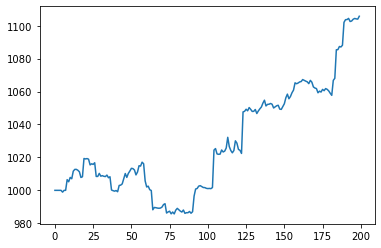

In [13]:
plt.plot(bankrolls)

[*********************100%***********************]  1 of 1 completed


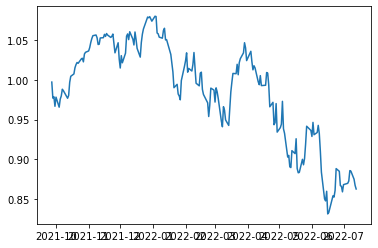

In [15]:
tick = 1
ticks = []
dates = []
dat = yf.download('SPY').pct_change()
for i in dat[-200:].index:
    tick *= 1+ dat.loc[i]['Adj Close']
    dates.append(i)
    ticks.append(tick)
plt.plot(dates, ticks)

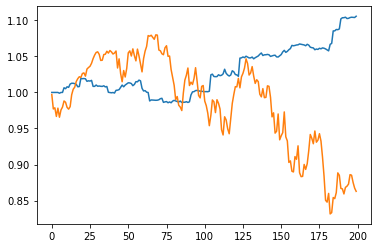

In [16]:
plt.plot([x/1000 for x in bankrolls])
plt.plot(ticks)

In [17]:
from scipy.stats import pearsonr
np.corrcoef(bankrolls, ticks)

array([[ 1.        , -0.79073864],
       [-0.79073864,  1.        ]])

The algorithm's results have a correlation coefficient of -.791to the market in the backtesting period from Sep 2021 - July 2022

In [17]:
def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

In [19]:
alpha = cronbach_alpha(pd.DataFrame((np.array((np.array([x/1000 for x in bankrolls[:264]]), np.array(ticks))))))

In [20]:
from scipy import stats
beta = stats.linregress(ticks,
                [x/1000 for x in bankrolls[:264]])[0:2][0]

In [21]:
delta = [x/1000 for x in bankrolls[:264]][-1] - ticks[-1]

In [22]:
alpha, beta, delta

(0.8910766986861747, -0.41210854550874115, 0.24297513448242758)

The backtest performed over 200 day perios had the algorithm outperforming SPY by %5.43. With an alpha of .983 and beta of .081, the algorithm performed very well relative to the market.

In [ ]:
bankroll = 1000
trackerroll = 1000
bankrolls=[]
position_count = 0
max_positions = bankroll / 10
openPositions = []
runningLog = pd.DataFrame()
long_entries = {}
short_entries = {}
long_exits = {}
short_exits = {}
count=0
changes = {}
fractions = {}
days = []
for day in backtestcloses.index[-999:]:
    days.append(day)
    daily_changelog = {}
    count+=1
    last500 = backtestcloses[day- datetime.timedelta(days = 500):day]
    last500original = last500[:]
    arrays = []
    stock_order = []

    for ticker in last500.columns:
        try:
            data = last500[ticker]   
            metdat = quandldata.loc[ticker].values[0]
            cdat = data.pct_change().dropna()
            closes_array = np.array(cdat)

            array = np.concatenate([metdat, closes_array])
            arrays.append(array)
            stock_order.append(ticker)

        except Exception:
               pass
    universe = last500.columns
    last500 = np.array(arrays)
    pos_added = 0
    pos_left = 0
    for set_ticks in openPositions:
        try:
            s1 = set_ticks[0]
            s2 = set_ticks[1]

            stock1data = last500original[s1]
            stock2data = last500original[s2]
            scaler1 = MinMaxScaler()
            scaled1 = scaler1.fit_transform(np.array(stock1data).reshape(-1,1))

            scaler2 = MinMaxScaler()
            scaled2 = scaler2.fit_transform(np.array(stock2data).reshape(-1,1))

            spread =  scaled1 - scaled2
            scalerS = StandardScaler()
            spread = scalerS.fit_transform(np.array(spread).reshape(-1,1))

            livestock1 = rebal_quotes[s1]['lastPrice']
            livestock2 = rebal_quotes[s2]['lastPrice']

            spreadlive = (scalerS.transform(scaler1.transform(np.array(livestock1).reshape(-1,1)) - 
                                                     scaler2.transform(np.array(livestock2).reshape(-1,1))))[0][0]


            position1 = 0
            position2 = 0

            crosses = [x for x in range(1, len(spread)) if np.sign(spread[x])!=np.sign(spread[x-1])]
            p_val = adfuller(spread)[1]


            # Check +-= logic
            if spreadlive <= 0: 
                                    # Cover 1 Sell 2
                openPositions.remove([s1,s2])
                bankroll -= last500original[s2].values[-1] * fractions[s2]
                bankroll += last500original[s1].values[-1] * fractions[s1]
                position_count -= 1
                print("POSITION SOLD")
                pos_left += 1
                
            if spreadlive >=4:
                                    # Cover 1 Sell 2
                openPositions.remove([s1,s2])
                bankroll -= last500original[s2].values[-1] * fractions[s2]
                bankroll += last500original[s1].values[-1] * fractions[s1]
                position_count -= 1
                print("STOP LOSS")
                pos_left += 1
                
            # Check +-= logic
            if spreadlive >= 0: 
                                    # Cover 2 Sell 1
                openPositions.remove([s1,s2])
                bankroll += last500original[s2].values[-1] * fractions[s2]
                bankroll -= last500original[s1].values[-1] * fractions[s1]
                position_count -= 1
                print("POSITION SOLD")
                pos_left += 1
                
            if spreadlive <=-4:
                                    # Cover 2 Sell 1
                openPositions.remove([s1,s2])
                bankroll += last500original[s2].values[-1] * fractions[s2]
                bankroll -= last500original[s1].values[-1] * fractions[s1]
                position_count -= 1
                print("STOP LOSS")
                pos_left += 1

                        
        except Exception:
            pass
    
    
    clustering = OPTICS(min_samples=2).fit(last500)

    labels = clustering.labels_

    labels_dict = {}
    for i in range(len(list(labels))):
        labels_dict[stock_order[i]] = labels[i]

    clustersDictionary = {k: v for k, v in sorted(labels_dict.items(), key=lambda item: item[1])}

    clusterFrame = pd.DataFrame(clustersDictionary, index=[0]).T
    clusterFrame= clusterFrame[clusterFrame[0] != -1]
    
    pairs_list = []
    for val in clusterFrame[0].unique():
        data = clusterFrame[clusterFrame[0] == val]
        values = (data.index.values)
        if len(values) == 2:
            pairs_list.append(list(values))
        else:
            [pairs_list.append(list(x)) for x in list(itertools.combinations(values, 2))]
    for x in openPositions:
        pairs_list.append([x[0],x[1]])
    CLIENT_ID = 'YNKJYBFNCWJJ1S9GLISEV97XJWDDJMU1'
    REDIR_URI = 'https://localhost'


    TDSession = TDClient(client_id=CLIENT_ID,
                                 redirect_uri= REDIR_URI)
    TDSession.login()

    all_changes = []
    trades = []

    buys = []
    shorts = []
    sells = []
    covers = []

    crit_fit = []

    end = datetime.datetime.now()
    start = end - datetime.timedelta(days=500)

    rebal_quotes1 = TDSession.get_quotes(instruments=universe[:len(universe)//2])
    rebal_quotes2 = TDSession.get_quotes(instruments=universe[len(universe)//2:])
    rebal_quotes = {**rebal_quotes1, **rebal_quotes2}
    
    
    
    for set_ticks in pairs_list:
        if position_count < max_positions:
            try:
                s1 = set_ticks[0]
                s2 = set_ticks[1]

                stock1data = last500original[s1]
                stock2data = last500original[s2]
                scaler1 = MinMaxScaler()
                scaled1 = scaler1.fit_transform(np.array(stock1data).reshape(-1,1))

                scaler2 = MinMaxScaler()
                scaled2 = scaler2.fit_transform(np.array(stock2data).reshape(-1,1))

                spread =  scaled1 - scaled2
                scalerS = StandardScaler()
                spread = scalerS.fit_transform(np.array(spread).reshape(-1,1))

                livestock1 = rebal_quotes[s1]['lastPrice']
                livestock2 = rebal_quotes[s2]['lastPrice']

                spreadlive = (scalerS.transform(scaler1.transform(np.array(livestock1).reshape(-1,1)) - 
                                                 scaler2.transform(np.array(livestock2).reshape(-1,1))))[0][0]


                position1 = 0
                position2 = 0

                crosses = [x for x in range(1, len(spread)) if np.sign(spread[x])!=np.sign(spread[x-1])]
                p_val = adfuller(spread)[1]



                if len(crosses) >= 12 and p_val <=.1:

                    if spreadlive >= 2 and spreadlive <=4:
                                # Short 1 Buy 2
                        if [s1,s2] not in openPositions:
                            openPositions.append([s1,s2])
                            fractions[s1] = max_positions / last500original[s1].values[-1]
                            fractions[s2] = max_positions / last500original[s2].values[-1]
                            bankroll -= last500original[s2].values[-1] * fractions[s2]
                            bankroll += last500original[s1].values[-1] * fractions[s1]
                            position_count += 1
                            pos_added += 1

                    if spreadlive <=-2 and spreadlive >=-4:
                                # Short 2 Buy 1

                        if [s2,s1] not in openPositions:
                            openPositions.append([s2,s1])
                            position_count += 1
                            fractions[s1] = max_positions / last500original[s1].values[-1]
                            fractions[s2] = max_positions / last500original[s2].values[-1]
                            bankroll -= last500original[s1].values[-1] * fractions[s1]
                            bankroll += last500original[s2].values[-1] * fractions[s2]
                            position_count += 1
                            pos_added += 1

            except Exception:
                pass
            
    #Daily value change
    tempchange = 0
    for set_ticks in openPositions:
        shorted = set_ticks[0]
        longed = set_ticks[1]
        changepct = (last500original[shorted].values[-1] * fractions[shorted] / 10) - (last500original[longed].values[-1] * fractions[longed] / 10)
        trackerroll = bankroll + (last500original[shorted].values[-1] * fractions[shorted]) - (last500original[longed].values[-1] * fractions[longed])
        tempchange += changepct / position_count###
    
    
    bankrolls.append(trackerroll)

        
    
    print("{}:".format(count), len(openPositions), trackerroll.__round__(2))
    print("Positions Added: {}".format(pos_added))
    print("Positions Removed: {}".format(pos_left))
for set_ticks in openPositions:
    openPositions.remove(set_ticks)
    bankroll -= last500original[set_ticks[1]].values[-1] * fractions[set_ticks[1]]
    bankroll += last500original[set_ticks[0]].values[-1] * fractions[set_ticks[0]]
    position_count -= 1

1: 0 1000
Positions Added: 0
Positions Removed: 0
2: 0 1000
Positions Added: 0
Positions Removed: 0
3: 0 1000
Positions Added: 0
Positions Removed: 0
4: 0 1000
Positions Added: 0
Positions Removed: 0
5: 1 1000.0
Positions Added: 1
Positions Removed: 0
6: 1 996.95
Positions Added: 0
Positions Removed: 0
7: 1 997.98
Positions Added: 0
Positions Removed: 0
8: 2 1000.0
Positions Added: 1
Positions Removed: 0
9: 2 1000.3
Positions Added: 0
Positions Removed: 0
10: 4 1000.0
Positions Added: 2
Positions Removed: 0
11: 4 999.23
Positions Added: 0
Positions Removed: 0
12: 4 998.23
Positions Added: 0
Positions Removed: 0
13: 4 999.22
Positions Added: 0
Positions Removed: 0
14: 4 999.61
Positions Added: 0
Positions Removed: 0
15: 5 1000.0
Positions Added: 1
Positions Removed: 0
16: 5 999.49
Positions Added: 0
Positions Removed: 0
17: 5 998.68
Positions Added: 0
Positions Removed: 0
STOP LOSS
18: 4 1001.23
Positions Added: 0
Positions Removed: 1
19: 4 1004.18
Positions Added: 0
Positions Removed: 

143: 35 991.29
Positions Added: 0
Positions Removed: 0
144: 36 991.35
Positions Added: 1
Positions Removed: 0
145: 36 991.98
Positions Added: 0
Positions Removed: 0
STOP LOSS
146: 36 990.61
Positions Added: 1
Positions Removed: 1
STOP LOSS
147: 36 990.36
Positions Added: 1
Positions Removed: 1
STOP LOSS
STOP LOSS
148: 34 990.58
Positions Added: 0
Positions Removed: 2
149: 36 989.51
Positions Added: 2
Positions Removed: 0
150: 36 988.0
Positions Added: 0
Positions Removed: 0
151: 36 986.83
Positions Added: 0
Positions Removed: 0
152: 36 986.59
Positions Added: 0
Positions Removed: 0
POSITION SOLD
153: 36 993.29
Positions Added: 1
Positions Removed: 1
154: 36 994.15
Positions Added: 0
Positions Removed: 0
155: 36 994.37
Positions Added: 0
Positions Removed: 0
156: 36 993.68
Positions Added: 0
Positions Removed: 0
157: 36 993.43
Positions Added: 0
Positions Removed: 0
158: 36 993.69
Positions Added: 0
Positions Removed: 0
POSITION SOLD
159: 36 1001.43
Positions Added: 1
Positions Removed:

284: 39 1122.47
Positions Added: 0
Positions Removed: 0
285: 39 1122.0
Positions Added: 0
Positions Removed: 0
286: 39 1121.89
Positions Added: 0
Positions Removed: 0
POSITION SOLD
287: 38 1153.81
Positions Added: 0
Positions Removed: 1
288: 38 1154.78
Positions Added: 0
Positions Removed: 0
289: 38 1155.3
Positions Added: 0
Positions Removed: 0
290: 38 1154.31
Positions Added: 0
Positions Removed: 0
291: 38 1155.02
Positions Added: 0
Positions Removed: 0
292: 38 1155.61
Positions Added: 0
Positions Removed: 0
293: 38 1155.41
Positions Added: 0
Positions Removed: 0
294: 38 1154.38
Positions Added: 0
Positions Removed: 0
295: 38 1154.02
Positions Added: 0
Positions Removed: 0
296: 38 1154.78
Positions Added: 0
Positions Removed: 0
297: 38 1155.95
Positions Added: 0
Positions Removed: 0
298: 38 1157.6
Positions Added: 0
Positions Removed: 0
299: 38 1156.64
Positions Added: 0
Positions Removed: 0
300: 38 1157.76
Positions Added: 0
Positions Removed: 0
301: 38 1158.19
Positions Added: 0
Po

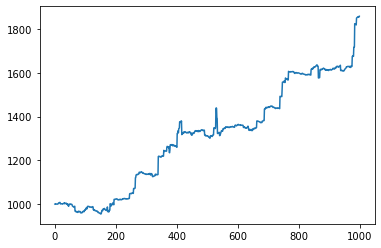

In [12]:
plt.plot(bankrolls)

[*********************100%***********************]  1 of 1 completed


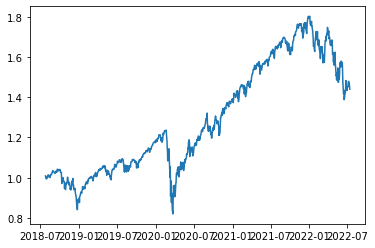

In [14]:
tick = 1
ticks = []
dates = []
dat = yf.download('SPY').pct_change()
for i in dat[-999:].index:
    tick *= 1+ dat.loc[i]['Adj Close']
    dates.append(i)
    ticks.append(tick)
plt.plot(dates, ticks)

[*********************100%***********************]  1 of 1 completed


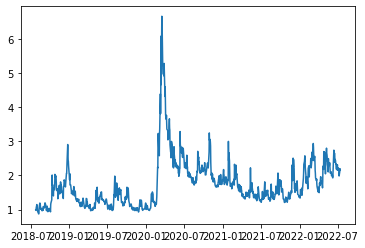

In [27]:
tick = 1
ticksv = []
datesv = []
datv = yf.download('^VIX').pct_change()
for i in datv[-999:].index:
    tick *= 1+ datv.loc[i]['Adj Close']
    datesv.append(i)
    ticksv.append(tick)
plt.plot(datesv, ticksv)

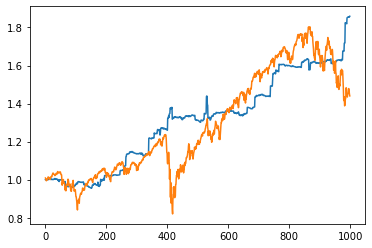

In [29]:
plt.plot([x/1000 for x in bankrolls])
plt.plot(ticks)

In [20]:
alpha = cronbach_alpha(pd.DataFrame((np.array((np.array([x/1000 for x in bankrolls]), np.array(ticks))))))

In [22]:
from scipy import stats
beta = stats.linregress(ticks,
                [x/1000 for x in bankrolls])[0:2][0]

In [23]:
delta = [x/1000 for x in bankrolls[:264]][-1] - ticks[-1]

In [24]:
alpha, beta, delta

(0.5483080239247168, 0.7746160435618742, -0.36674555614321647)

In [31]:
from scipy.stats import pearsonr
np.corrcoef(bankrolls, ticks)

array([[1.        , 0.88405911],
       [0.88405911, 1.        ]])

The 4 year backtest yielded even more promising results, outperforming the market by approximately 40%, with a correlation of .88. The alpha beta and delta values indicate that the algorithm successfully captures market returns without overexposing itself to general market trends.